****************************************************************************************************
# **Sistemas de Recomendación** - Filtro Colaborativo
****************************************************************************************************














#  **¿Cuál es la necesidad?**

Se require realizar un Sistema de Colaboración en este caso de filtro Colaborativo (basada en popularidad) para la Plataforma de videojuegos Steam

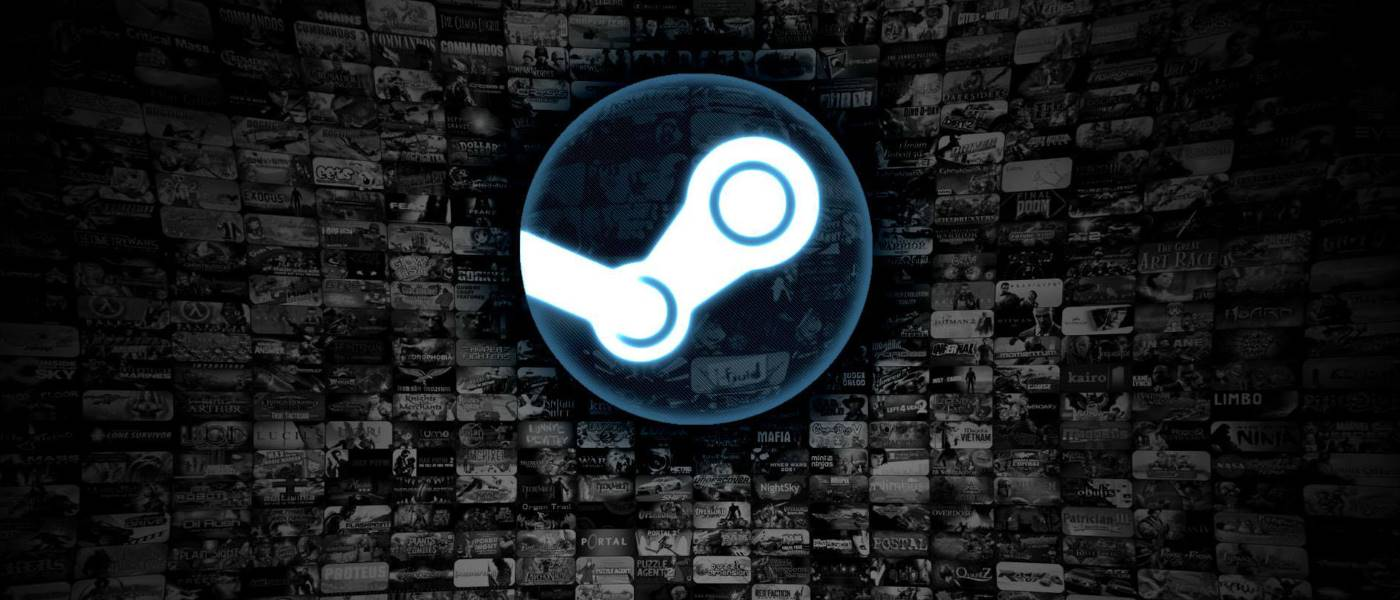

#  **¿Qué Utilizaremos?**



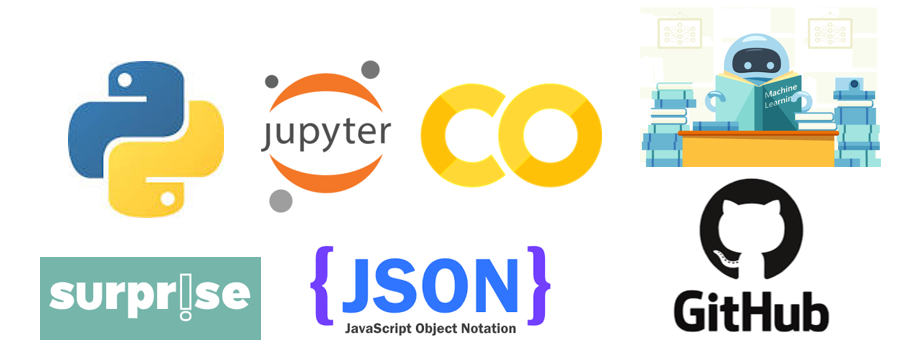

#  **Cómo lo Realizaremos?**

- Conocer Nuestros Datos
- Exploración de Datos
- Preguntas a Responder
- Filtro Colaborativo

In [6]:
import gzip
import pandas as pd

def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [7]:
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 10
for l in parse('steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1

In [8]:
data_reviews = pd.DataFrame(data_reviews)

In [9]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

****************************************************************************************************
# **DEA - Analisís Exploratorio de Datos**
****************************************************************************************************

### Reviews

In [10]:
data_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779307 entries, 0 to 779306
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   username      779307 non-null  object 
 1   hours         776670 non-null  float64
 2   products      777741 non-null  float64
 3   product_id    779307 non-null  object 
 4   page_order    779307 non-null  int64  
 5   date          779307 non-null  object 
 6   text          779307 non-null  object 
 7   early_access  779307 non-null  bool   
 8   page          779307 non-null  int64  
 9   user_id       317340 non-null  object 
 10  compensation  14588 non-null   object 
 11  found_funny   120164 non-null  float64
dtypes: bool(1), float64(3), int64(2), object(6)
memory usage: 66.1+ MB


### Games

In [11]:
data_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publisher       24083 non-null  object 
 1   genres          28852 non-null  object 
 2   app_name        32133 non-null  object 
 3   title           30085 non-null  object 
 4   url             32135 non-null  object 
 5   release_date    30068 non-null  object 
 6   tags            31972 non-null  object 
 7   discount_price  225 non-null    float64
 8   reviews_url     32133 non-null  object 
 9   specs           31465 non-null  object 
 10  price           30758 non-null  object 
 11  early_access    32135 non-null  bool   
 12  id              32133 non-null  object 
 13  developer       28836 non-null  object 
 14  sentiment       24953 non-null  object 
 15  metascore       2677 non-null   object 
dtypes: bool(1), float64(1), object(14)
memory usage: 3.7+ MB


## Campos Nulos

### Reviews

In [12]:
data_reviews.isna().sum()

username             0
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text                 0
early_access         0
page                 0
user_id         461967
compensation    764719
found_funny     659143
dtype: int64

### Games

In [13]:
data_games.isna().sum()

publisher          8052
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29458
dtype: int64

## Contenido

### Reviews

Visualizamos el contenido de la tabla junto con su tamaño

In [14]:
T_reviews = data_reviews.copy()
print('\n El DataSet Reviews Contiene: {} Filas y {} Columnas.' .format (T_reviews.shape[0] ,T_reviews.shape[1]) )


 El DataSet Reviews Contiene: 779307 Filas y 12 Columnas.


- De un total de **12 caracteristicas** nos quedamos con **5** las cuales consideré más importantes
- Así como tambien se cambio el nombre de la columna **id** a **product_id**
- Se incluyó un nuevo id de usuario **new_user_id**

In [15]:
T_reviews.head()
reduce_reviews = T_reviews.drop(['page_order', 'early_access', 'page','compensation','found_funny','date',], axis=1)
#reduce_reviews

In [16]:
# Creamos un id de usuario Nuevo , ya que no se cuenta con este dato completamente y es necesario para las siguientes consultas
data_user = reduce_reviews.copy()
usuarios = data_user['username'].unique()
username_id  = pd.DataFrame(usuarios,columns=['username'])
username_id

,username
0,Chaos Syren
1,Ariman1
2,freakfantom
3,The_Cpt_FROGGY
4,the_maker988
...,...
540336,Seikleja
540337,KindAlcoholic
540338,SepticFalcon
540339,RancorZealot


In [17]:
fin=len(username_id)+1
new_user_id = np.array(range(1,fin,1))
username_id['new_user_id'] = new_user_id
username_id

,username,new_user_id
0,Chaos Syren,1
1,Ariman1,2
2,freakfantom,3
3,The_Cpt_FROGGY,4
4,the_maker988,5
...,...,...
540336,Seikleja,540337
540337,KindAlcoholic,540338
540338,SepticFalcon,540339
540339,RancorZealot,540340


In [18]:
data_user = data_user.merge(username_id, left_on='username', right_on='username')
data_user = data_user.drop(['user_id'], axis=1)
data_user

,username,hours,products,product_id,text,new_user_id
0,Chaos Syren,0.1,41.0,725280,This would not be acceptable as an entertainme...,1
1,Ariman1,13.2,1386.0,328100,Addictive RPG ! Works fine on linux though it ...,2
2,Ariman1,0.5,1386.0,521230,I like this game.,2
3,Ariman1,2.0,1386.0,493980,Funny. A fast sim game.,2
4,freakfantom,0.1,1706.0,725280,Прикольная стрелялка. Взял дешево на распродаже.,3
...,...,...,...,...,...,...
779302,Seikleja,80.8,181.0,252490,"It is adictive, until some point, where you ju...",540337
779303,KindAlcoholic,1303.6,106.0,252490,I've been playing for for about two months bef...,540338
779304,SepticFalcon,334.9,402.0,252490,"A good laugh with friends, cannot wait till mo...",540339
779305,RancorZealot,203.5,173.0,252490,Should you buy RUST? Uh... YES. The BEST Survi...,540340


### Games

Visualizamos el contenido de la tabla junto con su tamaño

In [19]:
T_games = data_games.copy()
print('\n El DataSet Games Contiene: {} Filas y {} Columnas.' .format (T_games.shape[0] ,T_games.shape[1]) )


 El DataSet Games Contiene: 32135 Filas y 16 Columnas.


De un total de **16 carácteristicas** nos quedamos con **6** consideradas las más importantes

In [20]:
reduce_games = T_games.drop(['publisher','reviews_url','discount_price','genres','title', 'release_date', 'tags','specs','early_access','developer'], axis=1)
reduce_games.head()

,app_name,url,price,id,sentiment,metascore
0,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,4.99,761140,NaN,NaN
1,Ironbound,http://store.steampowered.com/app/643980/Ironb...,Free To Play,643980,Mostly Positive,NaN
2,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,Free to Play,670290,Mostly Positive,NaN
3,弹炸人2222,http://store.steampowered.com/app/767400/2222/,0.99,767400,NaN,NaN
4,Log Challenge,http://store.steampowered.com/app/773570/Log_C...,2.99,773570,NaN,NaN


In [21]:
#union de datos
reduce_games = reduce_games.rename(index = int, columns={"id": "product_id"})
data = pd.merge(data_user, reduce_games, on="product_id")
data = pd.DataFrame(data)
#print( '\n El DataSet Games Contiene: {} Filas y {} Columnas.' .format (data.shape[0] ,data.shape[1]))
#data

In [22]:
#validamos hasta donde podria haber un rango de horas
#plt.subplots(figsize=(15,3))
#sns.boxplot(x=data_reviews['hours'])
#plt.show()

****************************************************************************************************
# Preguntas a Responder
****************************************************************************************************

## ¿Cantidad de Productos Con Los Que Contamos?

Es importante conocer el número de nuestros productos, para saber con cuantos contamos

In [23]:
unicos = reduce_games['product_id'].nunique()
print(f'Contamos con : {unicos:,.2f} Productos')

Contamos con : 32,132.00 Productos


## ¿Que Clientes Adquieren Más Productos?

Cada usuario cuenta con un número de productos que ha adquirido, para obtener el total de productos por usuario, los sumamos de esta forma vemos que usuarios estan predispuestos a adquirir aún más

In [24]:
cliente_p = reduce_reviews[['username','products']]
clientes_p = pd.DataFrame(cliente_p) 
cliente_p = clientes_p.groupby(['username']).sum()
cliente_p = pd.DataFrame(cliente_p).reset_index()
cliente_p = cliente_p.sort_values(by = 'products', ascending = False)
cliente_product = cliente_p[:10]
cliente_product

,username,products
90789,Desolater IV,519085.0
492093,seph.au,291772.0
464959,mark | dj.,263588.0
293960,Salarn,262317.0
378572,XJ9,211924.0
462526,luckz,208909.0
383883,Youtube: Press start to begin,200632.0
409167,bipartisan homosexual wizard,199467.0
293528,Saint Aaron,192546.0
522057,~=^[(O){d_b}(O)]^=~,184880.0


In [25]:
import plotly as py
import plotly.graph_objs as go
import numpy as np
from scipy import special
py.offline.init_notebook_mode(connected=True)
## Usuarios que más adquieren productos
import plotly.graph_objects as go

fig = go.Figure(go.Bar(
            x= cliente_product.sort_values('products',ascending = False).username,
            y= cliente_product.sort_values('products',ascending = False).products,
            orientation='v'))

fig.update_traces(marker_color='#5BAEAD', marker_line_color='rgba (246, 78, 139, 1.0)',
                  marker_line_width=1.5, opacity=0.6)

fig.update_traces(texttemplate='%{y:.2s}', textposition='outside')

fig.update_layout(title_text='Usuarios , Productos Adquiridos')

fig.show()

## ¿Que Clientes Realizarón Más Reviews a los Productos?

De un total de **540,341** usuarios que realizaron reviews seleccioné los primeros 10 los cuales se muestran a continuación:

In [23]:
import plotly as py
import plotly.graph_objs as go
import numpy as np
from scipy import special
py.offline.init_notebook_mode(connected=True)

import plotly.express as px
reviews= reduce_reviews.groupby(['username']).size().reset_index(name = 'num_reviews')
reviews = reviews.sort_values(by ='num_reviews', ascending=False)[:10]
reviews = pd.DataFrame(reviews)

In [24]:
import plotly.graph_objects as go

fig = go.Figure(go.Bar(
            x= reviews.username,
            y= reviews.num_reviews,
            orientation='v'))

fig.update_traces(marker_color='#5BAEAD', marker_line_color='rgba (246, 78, 139, 1.0)',
                  marker_line_width=1.5, opacity=0.6)

fig.update_traces(texttemplate='%{y:s}', textposition='outside')

fig.update_layout(title_text='Top 10 , Usuarios que realizan más Reviews a los Productos')

fig.show()

## ¿ Cuáles son los 10 Productos con más Reviews?

Es importante tener la lista de los productos que más agradan a los usuarios para ofrecer nuevos u otros productos similares a quienes aún no tienen suficiente conocimiento en videojuegos o estan comenzando en este mundo.

In [25]:
reviews_mayoritarias = data.groupby(['product_id','app_name']).size().reset_index(name = 'num_reviews_del_producto')
reviews_mayoritarias = reviews_mayoritarias.sort_values(by ='num_reviews_del_producto', ascending=False)[:10]
top_10 = pd.DataFrame(reviews_mayoritarias)

In [26]:
import plotly as py
import plotly.graph_objs as go
import numpy as np
from scipy import special
py.offline.init_notebook_mode(connected=True)


fig = go.Figure(go.Bar(
            x= top_10.sort_values('num_reviews_del_producto',ascending = True).num_reviews_del_producto,
            y= top_10.sort_values('num_reviews_del_producto',ascending = True).app_name,
            orientation='h'))

fig.update_traces(marker_color='#5BAEAD', marker_line_color='rgba (246, 78, 139, 1.0)',
                  marker_line_width=1.5, opacity=0.6)

fig.update_traces(texttemplate='%{x:.2s}', textposition='outside')

fig.update_layout(title_text='Top 10 , Productos con más Reviews')

fig.show()

## ¿Puntajes Utilizados por los Criticos? 

Algunas personas que posiblemente prefieren una opinion de un grupo más selecto de criticos profesionales además de compartir opiniones más creibles y fiables a los productos deseen este tipo de información respecto de los usuarios que algunas veces solo dan una opinion vaga.



Los juegos estan calificados en un puntaje que va del **puntajes van de 20 - 96**  por lo que podemos ver que utilizan una **escala del 0 al 100 para evaluarlos**

criticas = data.groupby(['metascore']).size().reset_index(name = 'num_criticas')
criticas = criticas.sort_values(by ='num_criticas', ascending=True)
criticas = pd.DataFrame(criticas)
criticas.T

In [28]:
import plotly as py
import plotly.graph_objs as go
import numpy as np
from scipy import special
py.offline.init_notebook_mode(connected=True)

import plotly.graph_objects as go

fig = go.Figure(go.Bar(
            y=criticas.metascore,
            x= criticas.sort_values('num_criticas',ascending = True).num_criticas,
            orientation='h'))

fig.update_traces(marker_color='#FFD637', marker_line_color='black',
                  marker_line_width=0.5, opacity=0.6)

fig.update_traces(texttemplate='%{y:.2s}', textposition='outside')

fig.update_layout(title_text='Top 10 , Puntajes más utilizados por los criticos')

fig.show()

NameError: name 'criticas' is not defined

## ¿VideoJuegos Más Populares Entre Criticos?

De un Total de **150 Videojuegos** más populares por los criticos tomé **los primeros 10**

In [29]:
data_popular = data[  ( (data["metascore"] == 96 )  )  ]
data_popular = data_popular[['product_id','app_name','metascore']]
data_popular = data_popular.drop_duplicates(keep ='first')
#data_popular.size
data_popular

,product_id,app_name,metascore
94191,220,Half-Life 2,96
159881,271590,Grand Theft Auto V,96
323087,70,Half-Life,96
344748,7670,BioShock™,96


## ¿Cuales son los sentimientos más descatacos de los clientes hacia los Productos?

Saber que les provoca a los usuarios los productos que se ofrecen es fundamental para tratar de que se sientan comodos con los productos que consumen así mismo para saber como hacemos sentir al cliente y de esta forma mejorar el producto para hacerlo sentir mejor

Obtenemos el **Top 5 de Sentimientos**

In [30]:
sentimiento = data["sentiment"].value_counts(ascending =True)
sentimiento = pd.DataFrame(sentimiento)
sentimiento.T

,1 user reviews,3 user reviews,2 user reviews,Negative,7 user reviews,9 user reviews,5 user reviews,Very Negative,4 user reviews,8 user reviews,6 user reviews,Overwhelmingly Negative,Positive,Mostly Negative,Mostly Positive,Mixed,Overwhelmingly Positive,Very Positive
sentiment,187,284,290,317,317,318,345,347,367,367,388,675,4512,8352,108490,120782,148206,385263


In [346]:
#textos de los comentarios por los usuarios al juego
#data_user['text']
#data.info()

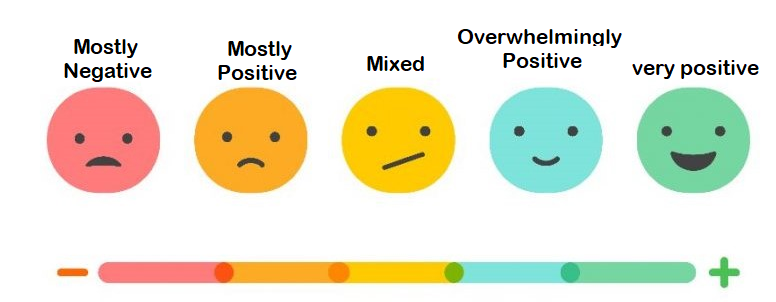

## ¿Que Palabras Destacan en los Comentarios de las Reviews?

MemoryError: 

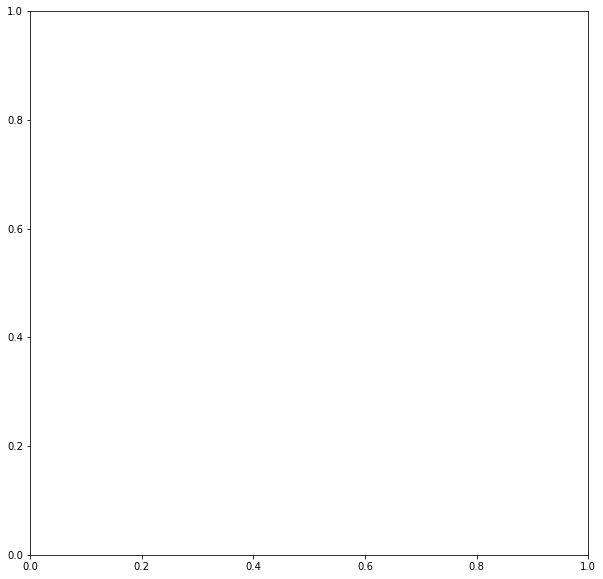

In [31]:
import plotly as py
import plotly.graph_objs as go
import numpy as np
from scipy import special
import matplotlib.pyplot as plt

py.offline.init_notebook_mode(connected=True)

# word cloud library
from wordcloud import WordCloud

x = data_user.text

plt.subplots(figsize = (10,10))

wordcloud = WordCloud (
                    background_color = 'white',
                    width = 412,
                    height = 400
                        ).generate(' '.join(x))
plt.imshow(wordcloud) # image show
plt.axis('off') # to off the axis of x and y
plt.savefig('Plotly-World_Cloud.png')
plt.show()

## ¿Que Clientes Invierten Más Tiempo Jugando?

In [209]:
#data

Saber quienes son los usuarios que más pasan dentro de la plataforma nos podría motivar a lanzar ya sea promociones, ofertas u otros productos parecidos a los que adquieren.

Del total de **540,341 usuarios** tomaremos nuestro **Top 10**



En el siguiente ejemplo se ve al **usuario 123** que adquirio varios juegos pero cada uno, de estos juegos, lo jugó por distintas horas.

In [33]:
informacion = data.copy()
cliente_h = informacion[['new_user_id','username','hours','product_id','app_name']]
clientes_h = pd.DataFrame(cliente_h) 
populares_p = cliente_h.copy()

In [34]:
clientes_h[clientes_h.username == '123']

,new_user_id,username,hours,product_id,app_name
5442,2908,123,44.8,214490,Alien: Isolation
5443,2908,123,33.6,214490,Alien: Isolation
5444,2908,123,27.1,214490,Alien: Isolation
17216,2908,123,2.1,239030,"Papers, Please"
22062,2908,123,34.2,35720,Trine 2: Complete Story
...,...,...,...,...,...
689276,2908,123,0.8,212160,Vindictus
689507,2908,123,0.8,436520,Line of Sight
689796,2908,123,2.5,476490,Choice of the Pirate
689802,2908,123,1.3,397150,Stellar Overload


Por cada uno de los usuarios se sumo el total de horas invertidas en cada uno de sus juegos.
- Una vez sumadas las horas del usuario 123 y todos los usuarios podemos ver el resultado.

In [35]:
cliente_h = clientes_h.groupby(['username']).sum()
cliente_h = pd.DataFrame(cliente_h).reset_index()
cliente_h = cliente_h.sort_values(by = 'hours', ascending = False)
cliente_hrs = cliente_h[:10]
cliente_hrs = pd.DataFrame(cliente_hrs)
cliente_hrs

,username,new_user_id,hours
5463,123,619404,196235.4
223575,Miss Teri,42006,28164.0
19181,Alex,295830,25884.5
8782,947183 / Terrix - Hourboost.com,35808,23200.3
310073,SkPeIIka,225339,23184.2
270034,Purple,376325,23031.5
164226,Jack,1308474,21005.8
487196,rizzed420,413061,20573.3
137416,Gospel,1064250,20437.8
491841,seigejet,1042834,20385.8


In [36]:
#¿Que Clientes Invierten Más Tiempo Jugando?
import plotly as py
import plotly.graph_objs as go
import numpy as np
from scipy import special
py.offline.init_notebook_mode(connected=True)

fig = go.Figure(go.Bar(
            x= cliente_hrs.sort_values('hours',ascending = False).username,
            y= cliente_hrs.sort_values('hours',ascending = False).hours,
            orientation='v'))

fig.update_traces(marker_color='#5BAEAD', marker_line_color='rgba (246, 78, 139, 1.0)',
                  marker_line_width=1.5, opacity=0.6)

fig.update_traces(texttemplate='%{y:.2s}', textposition='outside')

fig.update_layout(title_text='Usuarios , Clientes que Invierten Más Tiempo Jugando')

fig.show()

## ¿Cuáles Son Los Puntajes De Los Clientes Hacia Los Productos ?

No contamos con una calificación dada por los usuarios por lo que utilizamos **2 metricas**
la información de **sentimento**  y **horas jugadas**

- De acuerdo al siguiente criterio decidi dar un puntuaje por **horas Jugadas**

- La métrica de sentiment podría implementarse con un **analisis de sentimientos** con **Procesamiento de Lenjuage Natural**

- **Va de un rango del 1 - 5   siendo el 5 el máximo puntaje y el minimo 1**

In [37]:
#Total de todos los usuarios 
cliente_horas = data[['username','hours']]
total_user = cliente_horas.username.shape[0]
#total_user

In [38]:
#informacion necesaria con la cual se trabaja
c_h = populares_p
c_h

,new_user_id,username,hours,product_id,app_name
0,1,Chaos Syren,0.1,725280,Psi Project
1,3,freakfantom,0.1,725280,Psi Project
2,2,Ariman1,13.2,328100,Gunspell - Steam Edition
3,20,dll3z,0.4,328100,Gunspell - Steam Edition
4,34,Nyazicat,2.2,328100,Gunspell - Steam Edition
...,...,...,...,...,...
779946,517988,Botanic,4.3,763730,Ragtag Adventurers
779947,518108,ShippouViecher,1.9,654770,Ballway
779948,519834,PatQuinlan2017,5.8,421580,The Possession
779949,520293,S 7 4 L K 3 R,4.3,682070,MIND SHIFT 🔲


In [333]:
#Maximo de Horas
maxs = c_h["hours"].max()
#maxs

28164.0

In [39]:
#puntaje 5 estrellas
ranges = [0,10,50,100,250,30000]
e = c_h.groupby(pd.cut(c_h.hours, ranges)).count()
e['num_estrellas'] = [1,2,3,4,5]
e

,new_user_id,username,hours,product_id,app_name,num_estrellas
hours,,,,,,
"(0, 10]",319483,319483,319483,319483,319483,1
"(10, 50]",242331,242331,242331,242331,242331,2
"(50, 100]",73912,73912,73912,73912,73912,3
"(100, 250]",68172,68172,68172,68172,68172,4
"(250, 30000]",72957,72957,72957,72957,72957,5


In [40]:
import plotly as py
import plotly.graph_objs as go
import numpy as np
from scipy import special
import plotly.graph_objects as go
from plotly.subplots import make_subplots
py.offline.init_notebook_mode(connected=True)


labels = ["1 Estrellas", "2 Estrellas", "3 Estrellas", "4 Estrellas", "5 estrellas"] 
values = [e.hours[0], e.hours[1], e.hours[2], e.hours[3], e.hours[4]]

fig.data = []
fig.add_trace(go.Pie(labels=labels, values=values, name="Puntajes"))
# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.5, hoverinfo="label+percent+name")

fig.update_layout(
    title_text=" Puntajes Con Base a las Horas Jugadas ",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Score', x=0.50, y=0.5, font_size=25, showarrow=False)]
)
fig.show()


## ¿Cuáles son los juegos populares entre los Clientes?

De un **total de 72957** productos Calificados con **5 estrellas** seleccionamos 10

- Visualizamos todas las clasificaciones de los usuarios para posteriormente pasar a buscar las puntaciones más altas que en este caso serian **"5 estrellas"**

In [41]:
c_h['num_estrellas'] = c_h.apply(lambda x: 1.0if (x['hours'] > 0 and x['hours'] <= 10) else \
                             2.0if (x['hours'] > 10 and x['hours'] <= 50) else \
                             3.0if (x['hours'] > 50 and x['hours'] <= 100) else \
                             4.0if (x['hours'] > 100 and x['hours'] <= 250) else \
                             5.0if (x['hours'] > 250 and x['hours'] <= 30000) else \
                          0.0 , axis=1)
c_h
score_estrellas = pd.DataFrame(c_h)
score_estrellas

,new_user_id,username,hours,product_id,app_name,num_estrellas
0,1,Chaos Syren,0.1,725280,Psi Project,1.0
1,3,freakfantom,0.1,725280,Psi Project,1.0
2,2,Ariman1,13.2,328100,Gunspell - Steam Edition,2.0
3,20,dll3z,0.4,328100,Gunspell - Steam Edition,1.0
4,34,Nyazicat,2.2,328100,Gunspell - Steam Edition,1.0
...,...,...,...,...,...,...
779946,517988,Botanic,4.3,763730,Ragtag Adventurers,1.0
779947,518108,ShippouViecher,1.9,654770,Ballway,1.0
779948,519834,PatQuinlan2017,5.8,421580,The Possession,1.0
779949,520293,S 7 4 L K 3 R,4.3,682070,MIND SHIFT 🔲,1.0


- Visualizamos las puntuaciones con **5 Estrellas** de las cuáles seleccionamos **10 productos** para mostrar

In [42]:
Top_10 = score_estrellas[  ( (score_estrellas["num_estrellas"] == 5.0 )  ) ]

In [43]:
Top_10.drop_duplicates(subset=['app_name'])[:10]

,new_user_id,username,hours,product_id,app_name,num_estrellas
211,12443,Aiden,693.1,319630,Life is Strange - Episode 1,5.0
5344,407982,jango27375,303.5,311770,LEGO® Pirates of the Caribbean: The Video Game,5.0
5354,87961,Battle$tar,252.2,434650,Lost Castle,5.0
6062,487082,DoctorSandman,1000.1,214490,Alien: Isolation,5.0
7922,879,Kitty3Muffin,311.5,1840,Source Filmmaker,5.0
9170,220399,0xFFFFFF,932.0,285440,Crimzon Clover WORLD IGNITION,5.0
9552,371772,pukebarf,448.0,231200,Kentucky Route Zero,5.0
10033,3910,Lemon,599.5,221640,Super Hexagon,5.0
11478,13676,Dovahkiin,287.6,209000,Batman™: Arkham Origins,5.0
12490,9357,Chrono,513.1,274170,Hotline Miami 2: Wrong Number,5.0


## ¿Cuales son los juegos olvidados por los clientes?

De un **Total de 319302** productos impopulares tomaremos solo **10 para mostrar**

In [44]:
impopulares_10 = score_estrellas[  ( (score_estrellas["num_estrellas"] == 1.0 )  )  ]

In [45]:
impopulares_10.drop_duplicates(subset=['app_name'])[:10]

,new_user_id,username,hours,product_id,app_name,num_estrellas
0,1,Chaos Syren,0.1,725280,Psi Project,1.0
3,20,dll3z,0.4,328100,Gunspell - Steam Edition,1.0
9,2,Ariman1,0.5,521230,Stone Age Wars,1.0
16,2,Ariman1,2.0,493980,Green Ranch,1.0
17,4,The_Cpt_FROGGY,7.8,631920,Somewhere on Zibylon,1.0
20,4,The_Cpt_FROGGY,7.3,482440,ESSENCE,1.0
23,4,The_Cpt_FROGGY,4.7,736860,Hidden Object Adventure: Around the World in 8...,1.0
24,4,The_Cpt_FROGGY,8.3,493540,Figment,1.0
29,4,The_Cpt_FROGGY,5.7,341980,Dispatcher,1.0
53,4,The_Cpt_FROGGY,5.3,458680,Auto Age: Standoff,1.0


****************************************************************************************************
# **Filtro Colaborativo**
****************************************************************************************************

In [46]:
info_work = score_estrellas.copy()

In [236]:
#info_work.head()

## Información del DataSet con la que trabajaremos

Seleccionamos aquellos datos donde se encuentre el **id de usuario , id del producto y el ranking de los usuarios**

In [47]:
#Este dataframe tiene que tener siempre los ID de los usuarios, Id de productos y ratting dado usuario
f1 = info_work[["new_user_id","username", "product_id","app_name","num_estrellas"]]
f1

,new_user_id,username,product_id,app_name,num_estrellas
0,1,Chaos Syren,725280,Psi Project,1.0
1,3,freakfantom,725280,Psi Project,1.0
2,2,Ariman1,328100,Gunspell - Steam Edition,2.0
3,20,dll3z,328100,Gunspell - Steam Edition,1.0
4,34,Nyazicat,328100,Gunspell - Steam Edition,1.0
...,...,...,...,...,...
779946,517988,Botanic,763730,Ragtag Adventurers,1.0
779947,518108,ShippouViecher,654770,Ballway,1.0
779948,519834,PatQuinlan2017,421580,The Possession,1.0
779949,520293,S 7 4 L K 3 R,682070,MIND SHIFT 🔲,1.0


In [48]:
# Cargamos librerias
import gc #garbage collector
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from collections import defaultdict

In [49]:
reader = Reader(rating_scale=(1, 5))

In [50]:
#Usamos Reader() del paquete Surprise para poner los datos en el formato que nos piden los algoritmos
N_filas = 200000 #filas a cargar para no saturar la computadora
data = Dataset.load_from_df(f1[["new_user_id", "product_id","num_estrellas"]] [:N_filas], reader)

In [51]:
#Separo en train y test
set_entrenamiento, set_prueba = train_test_split(data, test_size=.20, random_state=42)

## Set de Prueba

In [409]:
set_prueba

[(291081, '55230', 3.0),
 (479010, '250110', 1.0),
 (95623, '6910', 3.0),
 (181417, '220', 2.0),
 (14119, '291550', 2.0),
 (307949, '440', 5.0),
 (464938, '252490', 4.0),
 (491055, '372000', 3.0),
 (17995, '377160', 3.0),
 (112080, '377160', 5.0),
 (341128, '238320', 1.0),
 (248509, '620', 1.0),
 (526080, '252490', 4.0),
 (381785, '219640', 2.0),
 (197408, '377160', 4.0),
 (375001, '219640', 2.0),
 (155003, '17460', 4.0),
 (5879, '211820', 3.0),
 (86775, '261640', 2.0),
 (65946, '211400', 1.0),
 (73028, '250340', 2.0),
 (335816, '239030', 2.0),
 (133678, '4000', 5.0),
 (29292, '314980', 4.0),
 (70052, '440', 5.0),
 (472217, '12220', 1.0),
 (486630, '253290', 1.0),
 (8921, '252490', 3.0),
 (40629, '271590', 5.0),
 (69196, '393380', 4.0),
 (307565, '440', 1.0),
 (271193, '280320', 1.0),
 (211275, '206440', 1.0),
 (335880, '319510', 1.0),
 (134044, '4000', 2.0),
 (240397, '393380', 2.0),
 (131008, '4000', 3.0),
 (399450, '203160', 2.0),
 (512986, '227300', 5.0),
 (40683, '220', 2.0),
 (25

## **Comparativa entre métricas (Modelo Benchmark)**

Los distintos **Modelos** utilizados fueron **SVDpp, SVD, NormalPredictor ,SVD_KFolk** y las **métricas** en cada uno de ellos fueron **MAE,RMSE,FCP** estas fueron seleccionadas ya que nos expresan el error de prediccion del modelo, además de ser muy a menudo usadas por ser métricas de modelado predeterminadas.

****************************************************************************************************
## **Método SVD**
****************************************************************************************************

In [55]:
#algortimo SVD
from surprise import SVD
svd = SVD()
svd.fit(set_entrenamiento)
predicciones_svd = svd.test(set_prueba)

In [ ]:
#Probamos con un usuario y producto, para ver su predicción
#svd.predict(98919,104900)

### SVD - (MAE) Error Absoluto Medio

In [56]:
svd_mae = accuracy.mae(predicciones_svd)

MAE:  0.7959


### SVD - (RMSE) Raiz del Error Cuadrático Medio

In [57]:
svd_rmse = accuracy.rmse(predicciones_svd)

RMSE: 1.0521


### SVD - (FCP) fracción de pares concordantes

In [58]:
svd_fcp = accuracy.fcp(predicciones_svd)

FCP:  0.5276


#### Se optimizan los parámetros con GridSearchCV

aún que este no mejoró se acercó a la métrica de SVD- RMSE de hecho tienen una diferencia minima de 0.006

In [59]:
##Tratamos de optimizar los parametros del modelo anterior con GridSearchCV
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors':[1,2,3],'n_epochs': [25,27,30], 'lr_all': [0.0015, 0.002],
              'reg_all': [0.01, 0.015,0.02]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5, n_jobs = -1, joblib_verbose=5)

In [60]:
gs.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 23.6min finished


In [61]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

1.059407029251752
{'n_factors': 3, 'n_epochs': 30, 'lr_all': 0.002, 'reg_all': 0.01}


****************************************************************************************************
## **Método SVD++**
****************************************************************************************************

In [72]:
#Instanciamos el algoritmo y entrenamos
from surprise import accuracy
from surprise import SVDpp
svdpp = SVDpp()
svdpp.fit(set_entrenamiento)
#Hacemos las predicciones con el conjunto de prueba
predicciones_svdpp = svdpp.test(set_prueba)

In [288]:
#Probamos con un usuario y producto, para ver su predicción
#svdpp.predict(98919,104900)

### SVD++  -  (MAE) Error Absoluto Medio

In [77]:
svdpp_mae =accuracy.mae(predicciones_svdpp)

MAE:  0.9236


###  SVD++ - (RMSE) Raiz del Error Cuadrático Medio 

In [78]:
svdpp_rmse = accuracy.rmse(predicciones_svdpp)

RMSE: 1.1865


### SVD++ - (FCP) fracción de pares concordantes

In [79]:
svdpp_fcp = accuracy.fcp(predicciones_svdpp)

FCP:  0.5522


****************************************************************************************************
## **Método Normal Predictor**
****************************************************************************************************

In [63]:
from surprise import NormalPredictor
from surprise.model_selection import cross_validate
# Evaluación
p  = cross_validate(NormalPredictor(), data,measures=['RMSE', 'MAE','FCP'], cv=3)
p

{'test_rmse': array([1.87401006, 1.87353305, 1.86739376]),
 'test_mae': array([1.5140423 , 1.5133557 , 1.50411782]),
 'test_fcp': array([0.48872786, 0.50461926, 0.48118536]),
 'fit_time': (0.7032835483551025, 0.6619889736175537, 0.7115747928619385),
 'test_time': (1.4038946628570557, 1.542121171951294, 1.5631017684936523)}

### NormalP - (MAE) Error Absoluto Medio

In [64]:
normal_mae = p['test_mae'][2]
print(' test_mae: {}'. format( normal_mae))

 test_mae: 1.5041178204018


### NormalP - (RMSE) Raiz del Error Cuadrático Medio

In [65]:
normal_rmse = p['test_rmse'][2]
print(' test_rmse: {}'. format( normal_rmse))

 test_rmse: 1.867393761631036


### NormalP - (FCP) fracción de pares concordantes

In [66]:
normal_fcp = p['test_fcp'][2]
print(' test_rmse: {}'. format( normal_rmse))

 test_rmse: 1.867393761631036


****************************************************************************************************
## **Método SVD_K-Folk**
****************************************************************************************************

In [67]:
from surprise.model_selection import KFold
kf = KFold(n_splits=3)

algo = SVD()

for trainset, testset in kf.split(data):
    # Entrenamiento, predicción
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Evaluación


### NormalP - (MAE) Error Absoluto Medio

In [68]:
kfolk_MAE = accuracy.mae(predictions, verbose=True)

MAE:  0.8066


### KFolk - (RMSE) Raiz del Error Cuadrático Medio

In [69]:
kfolk_RMSE = accuracy.rmse(predictions, verbose=True) # detallado: Si es verdadero, se imprimirá el resultado.

RMSE: 1.0565


### KFolk - (FCP) fracción de pares concordantes

In [70]:
kfolk_FCP = accuracy.fcp(predictions, verbose=True)

FCP:  0.5351


**Entre menor sea el margen de error , mejor será nuestro modelo**

En este caso el mejor método fue el kfolk ya que nos da un menor error de predicción, tanto para MAE y RMSE , tambien podemos ver que la métrica FCP tiene un menor margen de error en la predicción en todos los casos.

In [82]:
import plotly.graph_objects as go

fig = go.Figure( )
fig.add_trace(go.Bar(name="SVD", x=["MAE", "RMSE", "FCP"], y=[svd_mae,svd_rmse,svd_fcp]))
fig.add_trace(go.Bar(name="SVD++", x=["MAE", "RMSE","FCP"], y=[svdpp_mae,svdpp_rmse,svdpp_fcp]))
fig.add_trace(go.Bar(name="NormalPredictor", x=["MAE", "RMSE","FCP"], y=[normal_mae,normal_rmse,normal_fcp]))
fig.add_trace(go.Bar(name="SVD_KFolk", x=["MAE", "RMSE","FCP"], y=[kfolk_MAE,kfolk_RMSE,kfolk_FCP]))

fig.update_traces(texttemplate='%{y}', textposition='outside')
fig.update_layout(title_text='Comparación Método-Métricas -  (Benchmark)')

fig.show()

## Conclusiones

- Podriamos mejorar los parametros con gridsearch (a ún que me parece que para este caso , el error es aceptable ya que es bajo)


- Podriamos utilizar NPL Lenguaje de Procesamiento Natural para la información de sentimientos y/o para los comentarios de los usuarios respecto de los productos (caracteristica : text)


- La información que contiene el dataset podria utilizarse para elaborar un sistema de recomendación basado en Contenido


## **Próximos pasos**


Algunas preguntas planteadas durante el desarrollo del proyecto fueron,
¿Cómo analizar los sentimientos de los clientes hacia los videojuegos?, con el afán de contestar a esta pregunta se mostraron las palabras más frecuentes acerca de los comentarios que han hecho los usuarios destacando aquellas palabras que más se repiten, así como por medio de votación hacia los distintos sentimientos obtuve el top 5 de sentimientos más votados como lo fueron: (Very positive, overwhelmingly positive, Mixed, Mostly Positive, Mostly Negative),  sin embargo una forma de llevar esta información más a fondo sería utilizar
- **Análisis de sentimientos con Procesamiento de Lenguaje Natural o Análisis de Textos**, ya que saltan otras preguntas tales como, de acuerdo a las opiniones en más de un idioma
- **¿Cuál es el sentimiento que demuestran hacia los videojuegos?** Ya que estas podrían estar en diferentes idiomas**¿Cómo se podría resolver esto?**, o **¿Cómo obtener toda la información correspondiente de la página web de la plataforma?**,para apoyarnos de otras carácteristicas 

Los siguientes pasos seria realizar una investigación la cual se explica en el apartado "investigación"



## **Resultados esperados**


- **Procesamiento de Lenguaje Natural o Análisis de Textos** Con esto se espera conocer los sentimientos de los clientes hacia los videojuegos además se espera analizar los distintos idiomas de la plataforma la cual es muy conocida y tiene bastantes suscriptores en todo el mundo es importante saber el idioma del público al que nos dirigimos para saber sus gustos y preferencias es de suma importancia y para este caso saber lo que comentan en las reseñas
- **Con Obtener más información de la plataforma** se espera contar con toda la información disponible en la plataforma, adicional al dataset con el que se cuenta, como el número de likes que no encontramos o información que pudiera ser de ayuda o relevante para cubrir los dos puntos anteriormente mencionados.

## **Investigación**
La parte de investigación debe incluir quiero hacer tal cosa (objetivo), de tal forma (metodología) para obtener tales resultados.

Quiero realizar tal análisis de sentimientos o de textos desarrollando algo parecido a esta forma, con librerías como textblob
(nos da un puntaje de polaridad de  -1 a 1, si la palabra es negativa o positiva y
su subjetividad  de 0 - 1 , también pose una funcion .traslate(to = "en") para el caso de español la cual nos permite leer de acuerdo al idioma que queramos traducir) 
para obtener tales resultados de polaridad y subjetividad , obteniendo asi puntajes negativos o positivos hacia las reseñas realizadas por los usuarios.

https://unipython.com/analisis-de-sentimientos-con-textblob-y-vader/
https://textblob.readthedocs.io/en/dev/

Otra opción que va de la mano es VaderSentiment (un modelo basado en reglas para el análisis de sentimientos de texto de redes sociales) también Vader nos puede ayudar a manejar tanto textos en ingles como en español
https://pypi.org/project/vaderSentiment/
https://www.arsys.es/blog/analisis-sentimientos-python-jupyter-notebooks/
https://pypi.org/project/vaderSentiment/

Opcionalmente usar webscraping nos podría ayudar a obtener la máxima información de la plataforma, ya que si contamos con otras características al respecto podría aportarnos mayor información sobre los sentimientos de los clientes hacia los videojuegos utilizando Web-Scraping de acuerdo al manual:
https://realpython.com/beautiful-soup-web-scraper-python/
https://yanfei.site/docs/dpsa/references/PyWebScrapingBook.pdf